# Testing Maximum Power Point (MPP) Functions

This notebook tests the SQL functions defined in the `V2__mpp_functions.sql` migration file that analyze Maximum Power Point (MPP) tracking data for solar cell pixels.

## Functions to Test

1. `get_queryable_solar_cell_pixels()` - Lists all queryable solar cells and pixels
2. `get_pixel_activity_range()` - Determines the default activity range for a pixel
3. `get_mpp_data_for_pixel()` - Gets MPP data for a specific pixel (with both explicit time range and automatically determined range)

Let's test these functions and visualize some sample MPP data.

## Setup

In [1]:
# Install required packages if not already installed
!pip install psycopg2-binary sqlalchemy pandas matplotlib seaborn python-dotenv

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import os
from datetime import datetime, timedelta
import warnings
from dotenv import load_dotenv
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import os
from datetime import datetime, timedelta
import pytz
import warnings
from dotenv import load_dotenv
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Database Connection

Let's establish a connection to the TimescaleDB database where our MPP data is stored.

In [3]:
# Load environment variables from .env file if available
from pathlib import Path
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text
import pandas as pd

# Load environment variables from .env file if available
dotenv_path = Path("../.env")
if dotenv_path.exists():
    load_dotenv(dotenv_path)
    print(f"Loaded environment variables from {dotenv_path}")

# Database configuration from environment variables with fallbacks
DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST', 'timescaledb'),
    'port': int(os.getenv('POSTGRES_PORT', 5432)),
    'database': os.getenv('POSTGRES_DB', 'perocube'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', 'postgres')
}

# Print database connection info (excluding password)
print(f"Database connection: {DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']} as {DB_CONFIG['user']}")

# Create SQLAlchemy engine with connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

# Helper function to run SQL queries
def run_query(query, conn=None):
    """Execute SQL query and return results as DataFrame"""
    close_conn = False
    if conn is None:
        conn = engine.connect()
        close_conn = True
    
    try:
        result = pd.read_sql_query(query, conn)
        return result
    except Exception as e:
        print(f"Error executing query: {e}")
        print(f"Query: {query}")
        return None
    finally:
        if close_conn and conn:
            conn.close()

# Test connection and check if our functions exist
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT version();"))
        version = result.scalar()
        print(f"✅ Successfully connected to the database.")
        print(f"PostgreSQL version: {version}")
        
        # Check if our SQL functions are available
        result = conn.execute(text("""
            SELECT routine_name 
            FROM information_schema.routines 
            WHERE routine_name IN ('get_queryable_solar_cell_pixels', 'get_pixel_activity_range', 'get_mpp_data_for_pixel')
            AND routine_type = 'FUNCTION'
        """))
        
        functions = [row[0] for row in result]
        required_funcs = ['get_queryable_solar_cell_pixels', 'get_pixel_activity_range', 'get_mpp_data_for_pixel']
        
        if all(func in functions for func in required_funcs):
            print(f"✅ All required MPP functions are available.")
        else:
            missing = [func for func in required_funcs if func not in functions]
            print(f"⚠️ Warning: Some MPP functions are missing: {', '.join(missing)}")
            print(f"Available functions: {', '.join(functions) if functions else 'None'}")
            
except Exception as e:
    print(f"❌ Error connecting to database: {e}")

Database connection: timescaledb:5432/perocube as postgres
✅ Successfully connected to the database.
PostgreSQL version: PostgreSQL 15.12 on x86_64-pc-linux-musl, compiled by gcc (Alpine 13.2.1_git20240309) 13.2.1 20240309, 64-bit
✅ All required MPP functions are available.


## 1. Test: Finding Queryable Solar Cell Pixels

First, we'll test the `get_queryable_solar_cell_pixels()` function to see what solar cells and pixels are available for querying.

Found 80 queryable pixels across 34 solar cells


,solar_cell_name,pixel_identifier,first_connection_event_time,last_event_time,last_event_type_recorded
0,A11_100C,1,2023-04-19 00:00:00+00:00,2023-10-12 00:00:00+00:00,DISCONNECTED
1,A11_100C,2,2023-04-19 00:00:00+00:00,2023-10-12 00:00:00+00:00,DISCONNECTED
2,A23_110C,1,2023-04-19 00:00:00+00:00,2023-10-12 00:00:00+00:00,DISCONNECTED
3,A23_110C,2,2023-04-19 00:00:00+00:00,2023-10-12 00:00:00+00:00,DISCONNECTED
4,B11_120C,1,2023-04-24 00:00:00+00:00,2023-12-07 00:00:00+00:00,DISCONNECTED
...,...,...,...,...,...
75,QE-071221-17,A,2021-12-20 00:00:00+00:00,2022-12-16 00:00:00+00:00,DISCONNECTED
76,QE-071221-17,C,2021-12-20 00:00:00+00:00,2022-12-16 00:00:00+00:00,DISCONNECTED
77,QE-071221-17,E,2021-12-20 00:00:00+00:00,2022-12-16 00:00:00+00:00,DISCONNECTED
78,T2-2,C,2022-02-09 00:00:00+00:00,2022-07-15 00:00:00+00:00,DISCONNECTED


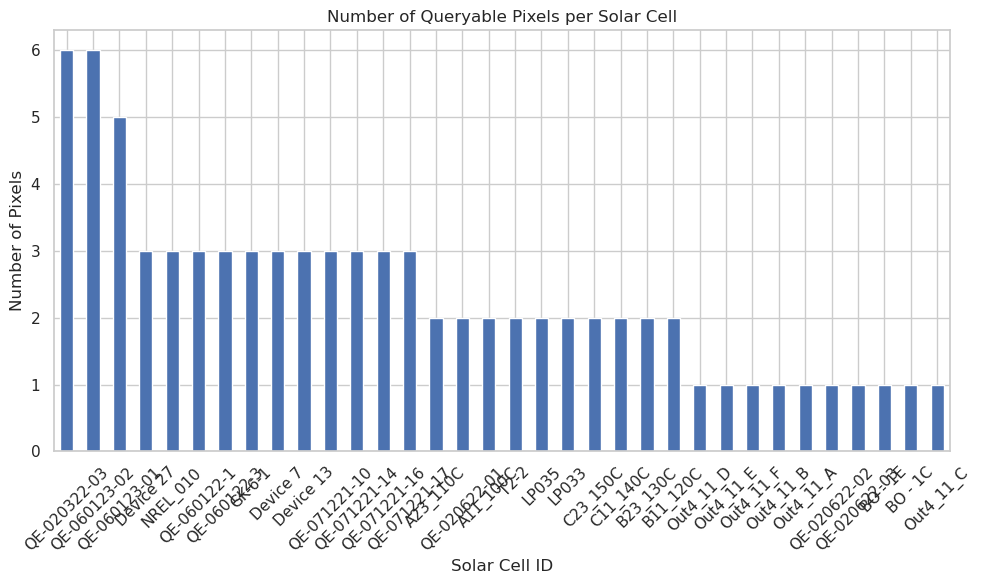

In [4]:
# Function to query the database and return results as pandas DataFrame
def run_query(query, conn=None):
    """Execute SQL query and return results as DataFrame"""
    close_conn = False
    if conn is None:
        conn = engine.connect()
        close_conn = True
    
    try:
        result = pd.read_sql_query(query, conn)
        return result
    except Exception as e:
        print(f"Error executing query: {e}")
        print(f"Query: {query}")
        return None
    finally:
        if close_conn and conn:
            conn.close()

# Test the get_queryable_solar_cell_pixels() function
query = """SELECT * FROM get_queryable_solar_cell_pixels();"""

queryable_pixels = run_query(query)

if queryable_pixels is not None and not queryable_pixels.empty:
    print(f"Found {len(queryable_pixels)} queryable pixels across {queryable_pixels['solar_cell_name'].nunique()} solar cells")
    display(queryable_pixels)
    
    # Create a visual summary
    plt.figure(figsize=(10, 6))
    cell_counts = queryable_pixels['solar_cell_name'].value_counts()
    cell_counts.plot(kind='bar')
    plt.title('Number of Queryable Pixels per Solar Cell')
    plt.xlabel('Solar Cell ID')
    plt.ylabel('Number of Pixels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No queryable pixels found or error executing the query.")

## 2. Test: Find Pixels with Actual MPP Data

Not all queryable pixels necessarily have MPP data. Let's identify which ones actually have data by testing a sample from each pixel.



In [ ]:
# Function to check if a pixel has MPP data
def check_pixel_data(solar_cell, pixel):
    """Check if a pixel has MPP data and return basic stats if it does"""
    # Use the overloaded function without explicit time range
    query = f"""SELECT COUNT(*) as count FROM get_mpp_data_for_pixel('{solar_cell}', '{pixel}');"""
    
    result = run_query(query)
    count = result['count'].iloc[0] if result is not None and not result.empty else 0
    has_data = count > 0
    
    return {
        'solar_cell': solar_cell,
        'pixel': pixel,
        'has_data': has_data,
        'row_count': count
    }

# Only proceed if we have queryable pixels
if queryable_pixels is not None and not queryable_pixels.empty:
    print(f"Testing all {len(queryable_pixels)} queryable pixels for MPP data...")
    
    # List to store results
    results = []
    
    # Test each pixel
    for _, row in queryable_pixels.iterrows():
        cell = row['solar_cell_name']
        pixel = row['pixel_identifier']
        
        print(f"Testing {cell}-{pixel}... ", end='')
        result = check_pixel_data(cell, pixel)
        results.append(result)
        
        # Print immediate feedback
        if result['has_data']:
            print(f"✅ Found {result['row_count']} rows of data")
        else:
            print(f"❌ No data")
    
    # Convert results to DataFrame for easier viewing
    results_df = pd.DataFrame(results)
    
    # Display summary
    print(f"\nSummary: Found {results_df['has_data'].sum()} pixels with data out of {len(results_df)} queryable pixels")
    
    # Display only pixels with data
    pixels_with_data = results_df[results_df['has_data'] == True].copy()
    if not pixels_with_data.empty:
        print(f"\nPixels with data ({len(pixels_with_data)}):\n")
        display(pixels_with_data)
        
        # Save a test pixel with data for further testing
        test_cell = pixels_with_data.iloc[0]['solar_cell']
        test_pixel = pixels_with_data.iloc[0]['pixel']
        print(f"\nSelected test case: Solar Cell '{test_cell}', Pixel '{test_pixel}'")
    else:
        print("\nNo pixels with MPP data were found.")
else:
    print("Cannot test pixels because no queryable pixels were found.")

Testing all 80 queryable pixels for MPP data...
Testing A11_100C-1... 

## 3. Test: Pixel Activity Range

Let's test the `get_pixel_activity_range()` function for our selected pixel.



In [ ]:
try:
    # Make sure we have a pixel with confirmed data from the previous cell
    pixel_to_analyze = f"{test_cell}-{test_pixel}"
    print(f"Testing activity range for {pixel_to_analyze}")
    
    # Get the full activity range for this pixel using get_pixel_activity_range
    query = f"""
    SELECT * FROM get_pixel_activity_range('{test_cell}', '{test_pixel}');
    """
    
    activity_range = run_query(query)
    
    if activity_range is not None and not activity_range.empty:
        start_time = activity_range['calculated_start_datetime'].iloc[0]
        end_time = activity_range['calculated_end_datetime'].iloc[0]
        
        print(f"\nActivity range found:")
        print(f"Start time: {start_time}")
        print(f"End time: {end_time}")
        duration = end_time - start_time
        print(f"Total duration: {duration}")
        
        # Now get the MPP data for this pixel using the overloaded function
        # (it will use the same activity range we just retrieved)
        mpp_query = f"""
        SELECT * FROM get_mpp_data_for_pixel('{test_cell}', '{test_pixel}');
        """
        
        mpp_data = run_query(mpp_query)
        
        if mpp_data is not None and not mpp_data.empty:
            data_start_time = mpp_data['timestamp'].min()
            data_end_time = mpp_data['timestamp'].max()
            
            print(f"\nRetrieved {len(mpp_data):,} MPP data points")
            print(f"Time range of data: {data_start_time} to {data_end_time}")
            
            # Check for incoherence between activity range and actual data time range
            print("\n--- Checking time range coherence ---")
            if data_start_time > start_time:
                time_diff = data_start_time - start_time
                print(f"⚠️ First data point is {time_diff} later than the calculated activity start time")
            elif data_start_time < start_time:
                time_diff = start_time - data_start_time
                print(f"⚠️ First data point is {time_diff} earlier than the calculated activity start time")
            else:
                print("✅ First data point matches activity start time exactly")
                
            if data_end_time < end_time:
                time_diff = end_time - data_end_time
                print(f"⚠️ Last data point is {time_diff} earlier than the calculated activity end time")
            elif data_end_time > end_time:
                time_diff = data_end_time - end_time
                print(f"⚠️ Last data point is {time_diff} later than the calculated activity end time")
            else:
                print("✅ Last data point matches activity end time exactly")
            
            print("\nSample of the data:")
            display(mpp_data.head())
            
            # Create a simple time-series plot of the power data
            plt.figure(figsize=(15, 6))
            plt.plot(mpp_data['timestamp'], mpp_data['power'], 'b-', alpha=0.6)
            plt.title(f'MPP Power Output for {pixel_to_analyze}')
            plt.xlabel('Time')
            plt.ylabel('Power (W)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            # Create a scatter plot of current vs. voltage
            plt.figure(figsize=(8, 6))
            plt.scatter(mpp_data['voltage'], mpp_data['current'], alpha=0.5, s=10)
            plt.title(f'Current vs. Voltage for {pixel_to_analyze}')
            plt.xlabel('Voltage (V)')
            plt.ylabel('Current (A)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            # Show a histogram of power values
            plt.figure(figsize=(10, 6))
            plt.hist(mpp_data['power'], bins=50, alpha=0.7)
            plt.title(f'Distribution of Power Values for {pixel_to_analyze}')
            plt.xlabel('Power (W)')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("No MPP data was found for this pixel, which is unexpected since the pixel should have data.")
    else:
        print(f"No activity range found for Solar Cell {test_cell}, Pixel {test_pixel}")
        
except NameError:
    print("Please run previous cells to identify a pixel with data")

## 4. Test: Explicit Time Range Query

Let's test the `get_mpp_data_for_pixel()` function with an explicit time range for our selected pixel.

In [ ]:
try:
    # Make sure we have a pixel with confirmed data
    pixel_to_analyze = f"{test_cell}-{test_pixel}"
    
    # Use the activity range we previously identified, but limit to a shorter period for testing
    # Sample a one-hour window if possible
    if 'start_time' in locals() and 'end_time' in locals():
        # If the total duration is longer than 1 hour, use a 1-hour window from the beginning
        if end_time - start_time > timedelta(hours=1):
            sample_start = start_time
            sample_end = start_time + timedelta(hours=1)
        else:
            # Otherwise, use the entire duration
            sample_start = start_time
            sample_end = end_time
        
        print(f"Testing explicit time range query for {pixel_to_analyze}")
        print(f"Time range: {sample_start} to {sample_end}")
        
        # Get MPP data for this specific time range
        query = f"""
        SELECT * FROM get_mpp_data_for_pixel(
            '{test_cell}', 
            '{test_pixel}', 
            '{sample_start}'::TIMESTAMP WITH TIME ZONE, 
            '{sample_end}'::TIMESTAMP WITH TIME ZONE
        );
        """
        
        mpp_sample_data = run_query(query)
        
        if mpp_sample_data is not None and not mpp_sample_data.empty:
            print(f"\nRetrieved {len(mpp_sample_data):,} MPP data points within the specified time range")
            print(f"Sample of the data:")
            display(mpp_sample_data.head())
            
            # Plot the power data for the sample time period
            plt.figure(figsize=(15, 6))
            plt.plot(mpp_sample_data['timestamp'], mpp_sample_data['power'], 'r-', alpha=0.6)
            plt.title(f'MPP Power Output for {pixel_to_analyze} (1-hour Sample)')
            plt.xlabel('Time')
            plt.ylabel('Power (W)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No MPP data found within the specified time range.")
    else:
        print("Please run the previous cell to identify the activity range first.")
        
except NameError:
    print("Please run previous cells to identify a pixel with data")